# Imports




In [ ]:
!pip install transformers -q
!pip install torch -q
!pip install sentence-transformers -q
!pip install nltk -q

from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
import torch

import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from random import sample
import re
import math
from torch.utils.data import Dataset, DataLoader
from transformers import (
    CONFIG_MAPPING,
    MODEL_WITH_LM_HEAD_MAPPING,
    AutoConfig,
    GPT2LMHeadModel, 
    GPT2Model,
    GPT2Tokenizer,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    LineByLineTextDataset,
    PreTrainedTokenizer,
    TextDataset,
    Trainer,
    TrainingArguments,
    set_seed,
    BertForSequenceClassification,
)

import math
import os
from dataclasses import dataclass, field
import pickle
import torch
from transformers import GPT2LMHeadModel, AutoTokenizer,AutoConfig
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from transformers import GPT2TokenizerFast
import pandas as pd

     |████████████████████████████████| 3.4 MB 8.1 MB/s 
     |████████████████████████████████| 895 kB 77.9 MB/s 
     |████████████████████████████████| 596 kB 100.5 MB/s 
     |████████████████████████████████| 3.3 MB 55.3 MB/s 
     |████████████████████████████████| 67 kB 6.9 MB/s 
     |████████████████████████████████| 78 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 19.3 MB/s 


# Importing the models and test data

## Cleaned test data:

In [1]:
!mkdir "/content/data_clean"
%cd data_clean





%cd ..

/content/data_clean
/content


In [ ]:
formal = pickle.load(open("/content/data_clean/formal_test.obj", "rb"))
informal0 = pickle.load(open("/content/data_clean/informal_test0.obj", "rb"))
informal1 = pickle.load(open("/content/data_clean/informal_test1.obj", "rb"))
informal2 = pickle.load(open("/content/data_clean/informal_test2.obj", "rb"))
informal3 = pickle.load(open("/content/data_clean/informal_test3.obj", "rb"))
formal_tune = pickle.load(open("/content/data_clean/formal_tune.obj", "rb"))
formal_train = pickle.load(open("/content/data_clean/formal_train.obj", "rb"))
informal_tune0 = pickle.load(open("/content/data_clean/informal_tune0.obj", "rb"))
informal_train = pickle.load(open("/content/data_clean/informal_train.obj", "rb"))

paranmt_dev = pickle.load(open("/content/data_clean/0_paranmt_dev.pickle", "rb"))
paranmt_train = pickle.load(open("/content/data_clean/0_paranmt_train.pickle", "rb"))
cleaned_paranmt = pickle.load(open("/content/data_clean/1_cleaned_paranmt.pkl", "rb"))
bleu_cleaned_paranmt = pickle.load(open("/content/data_clean/2_bleu_cleaned_paranmt.pkl", "rb"))

# acl_testing_0 = pickle.load(open("/content/data_clean/0_acl_testing.jsonl", "rb"))
# acl_training_0 = pickle.load(open("/content/data_clean/0_acl_training.jsonl", "rb"))
acl_cleaned_1 = pickle.load(open("/content/data_clean/1_cleaned_acl.pkl", "rb"))
acl_cleaned_train_1 = pickle.load(open("/content/data_clean/1_cleaned_acl_train.pkl", "rb"))
acl_testing_pair_2 = pickle.load(open("/content/data_clean/2_acl_testing_pair.pkl", "rb"))
acl_train_pair_2 = pickle.load(open("/content/data_clean/2_acl_train_pair.pkl", "rb"))
acl_cleanend_all_3 = pickle.load(open("/content/data_clean/3_all_acl_cleaned.pkl", "rb"))

"""
  dataset should be in the form [(in, out), (in, out), ..., (in, out)]
"""
def get_mixed_sample(dataset1, dataset2, amount):
  dataset = dataset1 + dataset2
  return sample(dataset, amount)

### Preparing Model 1 data

In [ ]:
# for i in range(100):
#   print(cleaned_paranmt[i][3], " -> ", cleaned_paranmt[i][4])

print(paranmt_dev[0][3], paranmt_train[0][3])

A person's character is reflected in his wathan. I guess it's up to me to save this family, then.


In [ ]:
total_paranmt = []
for i in range(len(paranmt_dev)):
  total_paranmt.append((paranmt_dev[i][3], paranmt_dev[i][4]))
for i in range(len(paranmt_train)):
  total_paranmt.append((paranmt_train[i][3], paranmt_train[i][4]))

total_GYAFC = []
for i in range(len(formal)):
  total_GYAFC.append((formal[i], informal0[i]))
for i in range(len(formal_tune)):
  total_GYAFC.append((formal_tune[i], informal_tune0[i]))
for i in range(len(formal_train)):
  total_GYAFC.append((formal_train[i], informal_train[i]))

In [ ]:
print(len(total_paranmt), len(total_GYAFC))

sample_GYAFC = sample(total_GYAFC, len(total_paranmt))
print(len(sample_GYAFC))

74554 111272
74554


In [ ]:
total_data_50_50 = total_paranmt + sample_GYAFC
total_data_50_50 = sample(total_data_50_50, 5120) #40 batches of 128

In [ ]:
pickle.dump(total_data_50_50, open("new_total_data_50_50", "wb"))

In [ ]:
# #Run this while importing total data 50 50
total_data_50_50 = pickle.load(open("/content/total_data_50-50.p", "rb"))

In [ ]:
print(total_data_50_50[:10])

[('Four suspected terrorists had been detained and were now undergoing interrogation.', 'they further were detained by the four suspects, who have now been subjected to questioning.'), ('You and Grandma want to stay in the room.', "you'll be staying with your grandmother."), ('If you just send him an email, then it means you are frightened', 'If you just send him an email, then that means ur scared'), ("Dr. Garner's agreed to drop the kidnapping charges if you turn over the boy.", 'when you give him the boy, Dr. Garner withdraws a kidnapping charge.'), ('Incoming breakers broke, spilling shatters of foam on the sand.', 'the waves crashed and splashed across the sand with showers of foam.'), ('Enjoy your time going out Enjoy your freedom', 'GO OUT AND HAVE A GOOD TIMEBE FREE'), ('Go into chat rooms that are in your peer group, and then introduce yourself', 'GO INTO CHAT ROOMS THAT ARE YOUR PEER GROUPINTRODUCE YOURSELF'), ('His distaste for America quailed before his hatred for the ruler

### Preparing Model 2 Data


In [ ]:
input_model2 = []
reference_output_model2 = []
for i in range(len(acl_testing_pair_2)):
  reference_output_model2.append(acl_testing_pair_2["input"].iloc[i])
  input_model2.append(acl_testing_pair_2["output"].iloc[i])

for i in range(len(acl_testing_pair_2)):
  reference_output_model2.append(acl_train_pair_2["input"].iloc[i])
  input_model2.append(acl_train_pair_2["output"].iloc[i])

data_pairs = []

for i in range(len(input_model2)):
  data_pairs.append((input_model2[i], reference_output_model2[i]))

total_model2_sample = sample(data_pairs, 5120)

In [ ]:
total_model2_sample = np.array(total_model2_sample)

open_file = open("total_model2_sample.p", "wb")
pickle.dump(total_model2_sample, open_file)
open_file.close()

In [ ]:
#or load from file:
total_model2_sample = pickle.load(open("/content/total_model2_sample.p", "rb"))

In [ ]:
pickle.dump(total_model2_sample, open("new_total_model2_sample", "wb"))

In [ ]:
reference_output_model2_sample = total_model2_sample[:, 1]
input_model2_sample = total_model2_sample[:, 0]

In [ ]:
input_model2_sample[10:20]

array([' shown in the left and right bracket is a symbol for the combination of the left and right braces, and we will call it the left and right bracket.',
       'as noted in the previous section, the calculation of the probability of a pcfg or a hmm is relatively complex.',
       'a Parser for Chinese Parses',
       'the analysis was not satisfactory, but the results were satisfying',
       'we have not yet implemented this option in the current system.',
       '.but the latter is more accurate than the former, at least for now.',
       'however, the model of Morphological Morphology is not addressed and the correspondence between sequence and morphological properties is not optimal',
       'the NUM method is not practical in practice',
       'we need to know how many times a verb is attested in a given context to estimate the probability of occurrence',
       'in very small quantities of training, the unconstrained model is incapable of continuing to grow'],
      dtype='<U

In [ ]:
reference_output_model2_sample[10:20]

array(['with a slight abuse of notation we now let them act as cover symbols standing for the sets of left and right brackets lcb a c rcb and lcb a c rcb respectively and we let m be the combined set u',
       'as noted in the previous section maximizing the conditional likelihood of a pcfg or a hmm can be computationally intensive',
       'we present a chinese parser based on abduction',
       'the problems of analysis were severe but the results gratifying',
       'in the current system we have not implemented this option',
       'while neither of these is absolutely correct the latter is generally much closer to the truth than the former',
       'however morphology is not addressed and the sequence correspondence model is less powerful than that employed in the back transliteration and spelling correction literature',
       'algorithm NUM is not a practical method for incremental feature selection',
       'in order to estimate the probability p f v we need to know how many t

## Fine-tuned models:

### Download: GPT2 - GYAFC Model:

In [2]:
!mkdir "/content/GYAFC_model"
%cd GYAFC_model


%cd ..

/content/GYAFC_model
/content


In [ ]:
#GYAFC trained GPT2 model (no rewards)
model_GYAFC = GPT2LMHeadModel.from_pretrained("/content/GYAFC_model/")
tokenizer_GYAFC = AutoTokenizer.from_pretrained("/content/GYAFC_model/")

### Download: GPT2 PARANMT Model

In [3]:
!mkdir "/content/PARANMT_model/"
%cd PARANMT_model



%cd ..



/content/PARANMT_model
/content


In [ ]:
#PARANMT trained GPT2 model (no rewards)
model_PARANMT = GPT2LMHeadModel.from_pretrained("/content/PARANMT_model/")
tokenizer_PARANMT = GPT2Tokenizer.from_pretrained("/content/PARANMT_model/")

Some weights of the model checkpoint at /content/PARANMT_model/ were not used when initializing GPT2LMHeadModel: ['transformer.extra_embedding_project.bias', 'transformer.extra_embedding_project.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Download: GPT2 GYAFC/PARANMT Model

In [4]:
!mkdir "/content/Combi_model/"
%cd Combi_model



%cd ..


/content/Combi_model
/content


In [ ]:
#GYAFC/PARANMT trained GPT2 model (no rewards)
model_combi = GPT2LMHeadModel.from_pretrained("/content/Combi_model/")
tokenizer_combi = AutoTokenizer.from_pretrained("/content/Combi_model/")

### Download: Model1 Rewards

In [5]:
!mkdir "/content/Model1_Rewards/"
%cd Model1_Rewards




%cd ..


/content/Model1_Rewards
/content


In [ ]:

model1_rewards = GPT2LMHeadModel.from_pretrained("/content/Model1_Rewards/")
tokenizer1_rewards = GPT2Tokenizer.from_pretrained("/content/Model1_Rewards/")

Some weights of the model checkpoint at /content/Model1_Rewards/ were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Download: Model 2

In [6]:
!mkdir "/content/Model2/"
%cd Model2



%cd ..


/content/Model2
/content


In [ ]:
model_2 = GPT2LMHeadModel.from_pretrained("/content/Model2/")
tokenizer_2 = AutoTokenizer.from_pretrained("/content/Model2/")

### Download: Model 2 (previous project)

1. Run all cells
2. Scroll down to the interactive part to explore GPT-2

In [7]:
! echo "Prepare download of GPT-2 model..."
! mkdir gpt2_model_2
%cd gpt2_model_2
! echo "download model checkpoint"

%cd ..

checkpoint = "/content/gpt2_model_2"

! echo "install libraries..."
!pip install -q git+https://github.com/huggingface/transformers
!pip install -q transformers torch

Prepare download of GPT-2 model...
/content/gpt2_model_2
download model checkpoint
/content
install libraries...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 596 kB 3.8 MB/s 
     |████████████████████████████████| 6.8 MB 54.0 MB/s 
     |████████████████████████████████| 895 kB 60.4 MB/s 
     |████████████████████████████████| 67 kB 5.0 MB/s 


In [ ]:
from transformers import pipeline, TextGenerationPipeline, GPT2LMHeadModel, AutoTokenizer

model2_1 = GPT2LMHeadModel.from_pretrained(checkpoint)
tokenizer2_1 = AutoTokenizer.from_pretrained(checkpoint, )
science_generator2_1 = TextGenerationPipeline(model=model2_1, tokenizer=tokenizer2_1, return_full_text=False)

In [ ]:
def processor(input):
  input_prompt = "<BOS>"+input+"<GENERATE_SCIENCE>"

  max_length= len(input_prompt)
  science = science_generator2_1(input_prompt, min_length = int(max_length/2), max_length = max_length, do_sample=True,
                repetition_penalty=1.1, temperature=1.2,
                top_p=0.55, top_k=50)

  x = science[0]['generated_text']
  output = ''
  for ch in x:
    if ch == '.':
      output += '.'
      break
    else:
      output += ch

  return output

In [ ]:
#@title Interactive

#@markdown Please set your sentences, that you would like to be transferred.
text = "The majority of CNN-based object detectors are largely applicable only for recommendation systems. For example, searching for free parking spaces via urban video cameras is executed by slow accurate models, whereas car collision warning is related to fast inaccurate models. Improving the real-time object detector accuracy enables using them not only for hint generating recommendation systems, but also for stand-alone process management and human input reduction. Real-time object detector operation on conventional Graphics Processing Units (GPU) allows their mass usage at an affordable price. T" #@param {type: "string"}

print(processor(text))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


in addition to the detection of objects based on CNN, they are used mainly in the recommendation system, with a large proportion of these objects for the system of recommendations.


### Download: Model 2 with rewards

In [8]:
!mkdir "/content/Model2_rewards/"
%cd Model2_rewards



%cd ..


/content/Model2_rewards
/content


In [ ]:
model_2_rewards = GPT2LMHeadModel.from_pretrained("/content/Model2_rewards/")
tokenizer_2_rewards = AutoTokenizer.from_pretrained("/content/Model2_rewards/")

Some weights of the model checkpoint at /content/Model2_rewards/ were not used when initializing GPT2LMHeadModel: ['v_head.summary.bias', 'v_head.summary.weight']
- This IS expected if you are initializing GPT2LMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2LMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Cleaning and Importing Model Ouputs:

### Model 1

In [ ]:
#Loading in the raw output data of the models:



raw_output_gyafc = pickle.load(open("/content/generated_outputs_GYAFC_Model.p", "rb"))
raw_output_paranmt = pickle.load(open("/content/generated_outputs_PARANMT_Model.p", "rb"))
raw_output_combi = pickle.load(open("/content/generated_outputs_Combi_Model.p", "rb"))
raw_output_model1_rewards = pickle.load(open("/content/generated_outputs_Model1_rewards.p", "rb")) 

In [ ]:
decoded_output_gyafc = []
decoded_output_paranmt = []
decoded_output_combi = []
decoded_output_model1_rewards = []

for i in range(len(raw_output_gyafc)):
  decoded_output_gyafc.append(tokenizer_GYAFC.decode(raw_output_gyafc[i][0]))
  decoded_output_paranmt.append(tokenizer_PARANMT.decode(raw_output_paranmt[i][0]))
  decoded_output_combi.append(tokenizer_combi.decode(raw_output_combi[i][0]))
  decoded_output_model1_rewards.append(tokenizer1_rewards.decode(raw_output_model1_rewards[i][0]))

In [ ]:
print(decoded_output_model1_rewards[:10])

['<BOS> I do; men break your heart, while friends stay forever <SCI_GEN> i do... men break ur heart... friends stay forever... <EOS> i do... men break ur heart... friends stay forever... <EOS> i do... men break ur heart... friends stay forever... <EOS> i do... men break ur heart... friends stay forever... <EOS> i do... men break ur heart... friends stay forever... <EOS> <EOS> i do... men break ur heart... friends stay forever... <EOS> <EOS> i do... men break ur heart... friends stay forever', '<BOS> You can acquire it from limewire, however you must download it <SCI_GEN> you can get it from limewire but u have to download it. <EOS> you can get it from limewire but u have to download it. <EOS> u can get it from limewire but u have to download it. <EOS> you have to download it... <EOS> u can get it from limewire... but u have to download it... <EOS> i guess... you just have to download it... <EOS>... u can get it from', '<BOS> I do not believe you can compare different cases of love <SCI

In [ ]:
output_gyafc = []
output_paranmt = []
output_combi = []
output_1_rewards = []
for i in range(len(decoded_output_gyafc)):
  g = decoded_output_gyafc[i].split("<SCI_GEN>")[1].split("<EOS>")[0]
  output_gyafc.append(g)

  p = decoded_output_paranmt[i].split("<SCI_GEN>")[1].split("<SCI _ GEN>")[0]
  p = p.split("<eos>")[0]
  output_paranmt.append(p)

  c = decoded_output_combi[i].split("<SCI_GEN>")[1].split("<EOS>")[0]
  output_combi.append(c)

  r = decoded_output_model1_rewards[i].split("<SCI_GEN>")[1].split("<EOS>")[0]
  output_1_rewards.append(r)

In [ ]:
output_1_rewards[:10]

[' i do... men break ur heart... friends stay forever... ',
 ' you can get it from limewire but u have to download it. ',
 ' i dont think you can say the same thing for love. ',
 ' she must have done an edit like i did for it. ',
 " that's how he got where he is now. ",
 ' "the entire ocean seems to be the same size," Nessus said. ',
 ' the statement said you were in the tunnel, right? ',
 ' Take the A Train by Duke Ellington Orchestra  Eighteen. ',
 ' the other guards fired at the copilot. ',
 " I'm not really short on cash so I try to be frugal. "]

In [ ]:
inputs_data = [x[0] for x in total_data_50_50]



In [ ]:
inputs_data[:10]

['I do; men break your heart, while friends stay forever',
 'You can acquire it from limewire, however you must download it',
 'I do not believe you can compare different cases of love',
 'She must have done an edit similar to the one I just did for it',
 'That is how it got where he is today',
 'Nessus said, "All the seas seem to be of the same order of magnitude."',
 "HQsaid you're at the tunnel, yeah?",
 'The song Take the A Train by Duke Ellington Orchestra Eighteen',
 'And the other guards returned fire on the copilot.',
 'I am short of cash so I try to be frugal']

In [ ]:
output_gyafc = pickle.load(open("/content/new_gyafc_output.p", "rb"))
output_paranmt = pickle.load(open("/content/new_outputs_paranmt.p", "rb"))
output_combi = pickle.load(open("/content/new_combi_output.p", "rb"))
output_model1_rewards = pickle.load(open("/content/new_model1_rewards_output.p", "rb"))


In [ ]:
output_model1_rewards

[tensor([[50257,    40,   466,    26,  1450,  2270,   534,  2612,    11,   981,
           2460,  2652,  8097, 50260,    72,   466,   986,  1450,  2270,  2956,
           2612,   986,  2460,  2652,  8097,   986, 50258,    72,   466,   986,
           1450,  2270,  2956,  2612,   986,  2460,  2652,  8097,   986, 50258,
             72,   466,   986,  1450,  2270,  2956,  2612,   986,  2460,  2652,
           8097,   986, 50258,    72,   466,   986,  1450,  2270,  2956,  2612,
            986,  2460,  2652,  8097,   986, 50258,    72,   466,   986,  1450,
           2270,  2956,  2612,   986,  2460,  2652,  8097,   986, 50258, 50258,
             72,   466,   986,  1450,  2270,  2956,  2612,   986,  2460,  2652,
           8097,   986, 50258, 50258,    72,   466,   986,  1450,  2270,  2956,
           2612,   986,  2460,  2652,  8097]]),
 tensor([[50257,  1639,   460, 12831,   340,   422,  1761,   413,   557,    11,
           2158,   345,  1276,  4321,   340, 50260,  5832,   460,   651,

In [ ]:
output_paranmt[:20]

[tensor([[   27,    33,  2640,    29,    40,   466,    26,  1450,  2270,   534,
           2612,    11,   981,  2460,  2652,  8097,    27,  6173,    40,    62,
          35353,    29,    40,  1101,  7926,    11,   475,   314,  1101,  7926,
             13,   314,  1101,  7926,    13,   314,  1101,  7926,    13,   314,
           1101,  7926,    13,   314,  1101,  7926,    13,   314,  1101,  7926,
             13,   314,  1101,  7926,    13,   314,  1101,  7926,    13,   314,
           1101,  7926,    13,   314,  1101,  7926,    13,   314,  1101,  7926,
             13,   314,  1101,  7926,    13,   314,  1101,  7926,    13,   314,
           1101,  7926,    13,   314,  1101,  7926,    13,   314,  1101,  7926,
             13,   314,  1101,  7926,    13,   314,  1101,  7926,    13,   314,
           1101,  7926,    13,   314,  1101]]),
 tensor([[   27,    33,  2640,    29,  1639,   460, 12831,   340,   422,  1761,
            413,   557,    11,  2158,   345,  1276,  4321,   340,    27,

In [ ]:
output_gyafc[:20]

[('', ''),
 ('I accepted it', ''),
 ('I believe so', ''),
 ('not in English', ''),
 ('A Cuban would know', ''),
 ('Attempt to download this', ''),
 ('Both individuals go free', ''),
 ('Do not tell anyone', ''),
 ('Do you drink beer', ''),
 ('He drugs famous women', ''),
 ('He earns with downloads', ''),
 ('He is not smart', ''),
 ('He is so disgusting', ''),
 ('I also love ', ''),
 ('I have distinct preferences', ''),
 ('I love all animals', ''),
 ('I prefer the guitarist', ''),
 ('It is an art', ''),
 ('It is too strange', ''),
 ('She calls him often', '')]

In [ ]:
model2_2outputs = pickle.load(open("/content/new_model2_2.p", "rb"))

In [ ]:
model2_2outputs[:5]

[('I guess so...', ' i guess so'),
 (' issues and topics are separated', ' topics and issues are separated'),
 ('I think john left.', ' i believe john to have left'),
 ('another day another change.', ' another change occurs'),
 ('e9 has another example', ' there are another two examples')]

### Model 2

In [ ]:
generated_outputs_Model2_2 = gen_outputs
# generated_outputs_Model2_2 = pickle.load(open("generated_outputs_Model2_2", "rb"))

In [ ]:
decoded_outputs_Model2_2 = []
for o in generated_outputs_Model2_2:
  decoded_outputs_Model2_2.append(tokenizer_2.decode(o[0]))

In [ ]:
decoded_outputs_Model2_2[:10]

['<BOS>a smoothing filter can be used to introduce new trends into temporally coherent frequencies<SCI_GEN>in addition a smoothing filter can be applied to temporally aligned frequencies to re engineer the frequency distributions<EOS>the technique of smoothing can be used to incorporate new trends into temporal co occurrence vectors<EOS>another approach to smoothing involves interpolation of smoothed frequencies on the temporally aligned frequencies<EOS>another is to incorporate smoothed frequencies on temporally aligned frequencies to re engineer the co occurrence vectors<EOS>another is to interpolate smoothed frequencies on',
 '<BOS>the central task is to set all events in order, so it can improve.<SCI_GEN>the set of all events is the central task so it can be improved<EOS>the set of all events is the central task so it should be improved<EOS>the set of all events has the potential to improve the results<EOS>the set of all events has the greatest potential for improvement because it 

In [ ]:
output_Model2_2 = []
for d in decoded_outputs_Model2_2:
  output_Model2_2.append(d.split("<SCI_GEN>")[1].split("<EOS>")[0])

In [ ]:
output_Model2_2[:10]

['in addition a smoothing filter can be applied to temporally aligned frequencies to re engineer the frequency distributions',
 'the set of all events is the central task so it can be improved',
 'in contrast prepositional phrases are much less amenable to distributional analysis',
 'let us illustrate the interpreter by an example',
 'in this terminology we chose the preferred interpretation since we were concerned with the description of negation and unnegated constituents in a formalism where the negation and unnegated constituents are not handled by distinct mechanisms',
 'we chose anova for our analysis method because the variables we are interested in are normal',
 'thus i will say that downstep has no effect on tones on either side thus ohl4h ph h lsl lii lii liii',
 'although strict word by word incrementality is not possible in deterministic dependency parsing the naive algorithm can in principle be equated with incremental parsing',
 'this results in a system in which individu

In [ ]:
input_model2_sample[:10]

array(['a smoothing filter can be used to introduce new trends into temporally coherent frequencies',
       'the central task is to set all events in order, so it can improve.',
       'in contrast, the prepositional phrase is much more susceptible to analysis in terms of distribution.',
       "let's see how the interpreter translates the example.",
       'the preferred interpretation is described in this terminology, as we were concerned with the description of the negation and the unmitigated parts of the alternative interpretation.',
       'because our analysis method is based on anova, we choose anova because the variables we are interested in are normal',
       'so i will say that downstep has no effect on tones on either side, so ohl4h ph h lsl lii lii liii',
       'in deterministic dependency analysis, the naive algorithm can in principle be compared to incremental parsing, although strict word by word increments of word length are not possible.',
       'that leads to a s

In [ ]:
reference_output_model2_sample[:10]

array(['one way to incorporate trends implicitly is to run a smoothing filter across the temporally aligned frequencies',
       'the central task the ordering of all events leaves lots of room for improvement',
       'in contrast prepositional phrases are much less amenable to distributional analysis',
       'let us illustrate the way the interpreter works with an example',
       'this terminology was used because we were concerned with describing the negated and unnegated parts of the preferred interpretation without referring to presuppositions',
       'we selected anova as our analysis method because our prosodic target variables appear to have a normal distribution',
       'concerning downstep i shall assume that the magnitude of downstep is independent of the tones on either side and so ohl4h ph h lsl lii i l',
       'it seems fair to conclude that although strict word by word incrementality is not possible in deterministic dependency parsing the arc eager algorithm can in 

In [ ]:
generated_outputs_Model2_1 = pickle.load(open("/content/generated_outputs_Model2_1.p", "rb"))

In [ ]:
input_model2_sample[:10]

array(['a smoothing filter can be used to introduce new trends into temporally coherent frequencies',
       'the central task is to set all events in order, so it can improve.',
       'in contrast, the prepositional phrase is much more susceptible to analysis in terms of distribution.',
       "let's see how the interpreter translates the example.",
       'the preferred interpretation is described in this terminology, as we were concerned with the description of the negation and the unmitigated parts of the alternative interpretation.',
       'because our analysis method is based on anova, we choose anova because the variables we are interested in are normal',
       'so i will say that downstep has no effect on tones on either side, so ohl4h ph h lsl lii lii liii',
       'in deterministic dependency analysis, the naive algorithm can in principle be compared to incremental parsing, although strict word by word increments of word length are not possible.',
       'that leads to a s

In [ ]:
reference_output_model2_sample[:10]

array(['one way to incorporate trends implicitly is to run a smoothing filter across the temporally aligned frequencies',
       'the central task the ordering of all events leaves lots of room for improvement',
       'in contrast prepositional phrases are much less amenable to distributional analysis',
       'let us illustrate the way the interpreter works with an example',
       'this terminology was used because we were concerned with describing the negated and unnegated parts of the preferred interpretation without referring to presuppositions',
       'we selected anova as our analysis method because our prosodic target variables appear to have a normal distribution',
       'concerning downstep i shall assume that the magnitude of downstep is independent of the tones on either side and so ohl4h ph h lsl lii i l',
       'it seems fair to conclude that although strict word by word incrementality is not possible in deterministic dependency parsing the arc eager algorithm can in 

In [ ]:
generated_outputs_Model2_1[:10]

['new developments in temporal coherent frequency may be introduced using a smoothing filter.',
 'the main task is setting up all events so that they can be improved.',
 'however, in terms of distribution, this preposition is much more vulnerable than its counterpart.',
 "we'll check how the interpreter translates the example.",
 'in this context, we refer to the negation of the implication, as we described in the description of the non-negativity and the undirected part of the alternative interpretation.',
 'since our analysis is based only on anova, we chose anova because the variables we care about are normal.',
 "so I'm saying that the downstep is no longer affecting the tone of either side, so ohl4h ph lsl lii liiiand I'm saying it's not affecting the tonal tone of any other side.",
 'the naive algorithm can, in principle, compare with incremental processing, though it is impossible for the word size scale to be applied.',
 'thus, in which each sentence is divided according to the

### Model 2 rewards

In [ ]:
m2_context_original = pickle.load(open("/content/m2_w_context_original_list", "rb"))
m2_context_output = pickle.load(open("/content/m2_w_context_output_list", "rb"))
m2_context_context = pickle.load(open("/content/m2_w_context_context_list", "rb"))
m2_context_non_scientific = pickle.load(open("/content/m2_w_context_non_scientific_list", "rb"))


In [ ]:
print(m2_context_original[:10])

['the basic idea is quite simple', 'we are grateful to the referee for helpful comments and suggestions to improve the presentation of this paper', 'schmidt orthogonalization', 'dw acknowledges support from the ctc', 'it may improve our understanding of the thermal evolution and thermal spectrum of magnetars', 'however , the majority of loops show more complicated trajectories', 'oscillating red line shows the calculation result', 'in quantum information processing , information is stored and processed with a quantum system', 'the second case is that universal gaugino masses are given above the gut scale', 'the qualitative difference between data for known bulk surfaces and our result should be attributed on movement of cu atoms in the reconstruction process']


In [ ]:
print(m2_context_output[:10])

[' the main difference is the choice of the energy scale ', ' we are grateful to the referee for helpful comments and suggestions on the manuscript ', ' schmidt orthogonalization ', ' dw acknowledges support from the stfc ', ' it might help us understand the thermal evolution and spectrum of magnetars ', ' however, the majority of loops show more complicated trajectories ', ' oscillating red line shows the calculation result ', ' qubits are the quantum information processing devices ', ' the second case is that the two-dimensional gi balls are above the gut scale ', ' the difference between the surface area of a brick and the volume of the brick is just 15 ']


In [ ]:
print(m2_context_context[:10])

[None, '<BOS>these effects are measured by the second term in', '<BOS>following an expansion analogous to eq[SEP]the moment hierarchy would comprise linear combinations of the coefficients[SEP]the problem is essentially an algebraic question of gram', '<BOS>dm is supported by the cambridge centre for theoretical cosmology (ctc)[SEP]ds is funded by stfc', None, '<BOS>the footpoints described quite a rectilinear path , similarly to emerging active regions and ephemeral regions', '<BOS>we apply the statefinder diagnostics to the torsion cosmology', None, None, None]


In [ ]:
print(m2_context_non_scientific[:10])

["it's pretty much the same", 'we are glad the ref gave us some help on this paper', 'i think that schmidt orthogonalizes to some degree', 'dw: hey guys, we got your back!', 'it might help us understand the thermal evolution and spectrum of magnetars', 'however, the majority of loops show more complicated trajectories', 'oscillating red line shows the calculation result', 'qubits are the bits of information that are used in information processing', 'the second case is that the 2nd kind of gi balls are above the gut scale', 'the difference between the surface area of a brick and the volume of the brick is just 15x']


# Content Preservation:



## Sentence embedding approach

In [ ]:
# from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('paraphrase-albert-small-v2')


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.71k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/827 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/46.7M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/465 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def cosine_sim(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

"""
  Takes in a list of sentences and returns a list of their sentence embedding vector
"""
def sent_embedding(sentences):
  tokenized_sent = []
  for s in sentences:
      tokenized_sent.append(s.lower().replace(",", ""))
  sentence_embeddings = sbert_model.encode(tokenized_sent)
  return sentence_embeddings



In [ ]:
# emb_a = sent_embedding([formal[100]])
# emb_b = sent_embedding([informal2[145]])

# print(cosine_sim(emb_a[0], emb_b[0]))

In [ ]:
# s1 = "I am taking my dog for a walk"
# s2 = "I am playing red dead redemption 2 on playstation"
# s3 = "My dog is at the park"
# s4 = "Apples are red and giraffes are tall"
# s5 = "I am cooking dinner"
# s6 = "I am chopping trees"
# s7 = "monkey, donkey, working as a data analyst in new york for money"
# s8 = "monkey, donkey, Hello I am elon musk and I want to go to space goodbye"



# sents = [s1, s2, s3, s4, s5, s6, s7, s8]


# sent_emb = sent_embedding(sents)



In [ ]:
# for i in range(len(sents)):
#   for j in range(i, len(sents)):
#     print(f'{sents[i]} and {sents[j]} are {cosine_sim(sent_emb[i], sent_emb[j])}')

In [ ]:
# The more similar a sentence is, the better the content would be preserved.

## Visualizing content preservation:

In [ ]:
# Use UMAP? Supposedly encodes meaning better


"""
  Takes a list of lists of sentence embeddings and colours each list its own colour
  A = [[se1, se2, ...., sen],
       [se1, se2, ...., sem],
       .
       .
       .
      ]
"""
def visualize_embeddings(A, titles, dimensions=2):
    reduced_list = []
    for a in tqdm(A):
      a_reduced = reduce_dimensionality(a, dimensions)
      reduced_list.append(a_reduced)

    color_list = ["blue", "red", "green", "orange", "pink", "purple", "cyan"]
    
    # TODO: 3D plots?
    for i in range(len(reduced_list)):
      r = reduced_list[i]
      color = "tab:"+color_list[i]
      
      plt.scatter(r[:,0], r[:,1], s=10, c=color, label=titles[i])
      plt.xlabel("PC1", size=15)
      plt.ylabel("PC2", size=15)
      plt.title("Sentence Embedding Space",size=20)
      plt.legend()
      # vocab=list(model.wv.vocab)
      # for i, word in enumerate(vocab):
      #   plt.annotate(word,xy=(neww_X[i,0],neww_X[i,1]))
    plt.show()
    
    

def reduce_dimensionality(embedding_list, dimensions=2):
  df = pd.DataFrame(embedding_list)
  print(df.head())
  #Computing the correlation matrix
  X_corr=df.corr()

  #Computing eigen values and eigen vectors
  values,vectors=np.linalg.eig(X_corr)

  #Sorting the eigen vectors coresponding to eigen values in descending order
  args = (-values).argsort()
  values = vectors[args]
  vectors = vectors[:, args]

  #Taking first 2 components which explain maximum variance for projecting
  new_vectors=vectors[:,:dimensions]
  #Projecting it onto new dimesion with 2 axis
  neww_X=np.dot(embedding_list,new_vectors)
  return neww_X
    



In [ ]:
# ea =  sent_embedding( formal[: 1000]    )
# eb =  sent_embedding( informal0[: 1000] )
# ec =  sent_embedding( informal1[: 1000] )
# ed =  sent_embedding( informal2[: 1000] )
# ee =  sent_embedding( informal3[: 1000] )





In [ ]:
# visualize_embeddings([ea, eb, ec, ed, ee], ["formal", "informal0", "informal1", "informal2", "informal3"], 2)

In [9]:


f = open('/content/guardian.txt', 'r')
guardian = f.read()
f.close()

f = open('/content/shakespeare.txt', 'r')
shakespeare = f.read()
f.close()


guardian_list = guardian.split(".")
shakespeare_list = shakespeare.split(".")

FileNotFoundError: ignored

110
100
99


  0%|          | 0/2 [00:00<?, ?it/s]

        0         1         2    ...       765       766       767
0 -0.254754  0.841339 -0.261596  ... -0.265298 -0.674365 -0.306814
1  0.025067 -0.444306  0.124448  ... -0.476865 -0.422103  0.159993
2 -0.844560  0.325235 -0.084296  ...  0.613818 -0.362765  0.565210
3 -0.473402 -0.337111  0.843718  ... -0.584968 -0.549722 -0.458340
4 -0.201149 -0.082261  0.363619  ... -0.173576 -0.507978 -0.973958

[5 rows x 768 columns]


 50%|█████     | 1/2 [00:00<00:00,  1.01it/s]

        0         1         2    ...       765       766       767
0  0.325448 -0.215348 -0.458145  ... -1.047840  0.548801 -0.176521
1  0.209323  0.430457  0.306622  ... -0.051950  0.300349 -0.453013
2  0.095154 -0.119536  0.327762  ...  0.700704  0.920636 -0.819238
3  0.438501  0.076014  0.089661  ... -0.747679 -1.062958 -1.248935
4  0.195879 -0.222254 -0.443813  ... -0.198861 -0.137732 -0.315868

[5 rows x 768 columns]


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


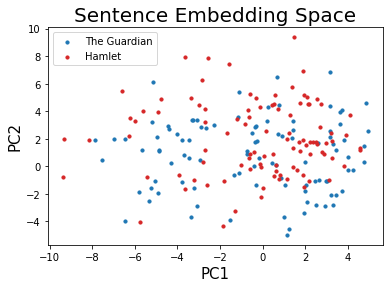

In [ ]:
shakespeare_use = []
guardian_use = []

print(len(guardian_list))
for i in range(100):
  if len(guardian_list[i]) > 4:
    guardian_use.append(guardian_list[i])
  if len(shakespeare_list[i]) > 4:
    shakespeare_use.append(shakespeare_list[i])

print(len(shakespeare_use))
print(len(guardian_use))


guardian_emb = sent_embedding(guardian_use)
shakespeare_emb = sent_embedding(shakespeare_use)

visualize_embeddings([guardian_emb, shakespeare_emb], ["The Guardian", "Hamlet"], 2)

## Dhruv's content preservation approach

In [ ]:
!pip install -r /content/requirements.txt

In [ ]:
import argparse
from models import load_model

parser = argparse.ArgumentParser()
parser.add_argument("--load-file", default = "/content/model.para.lc.100.pt",help="path to saved model")
parser.add_argument("--sp-model", default = "/content/paranmt.model",help="sentencepiece model to use")
parser.add_argument("--gpu", default=1, type=int, help="whether to train on gpu")

args = parser.parse_args(args=[])

content_pres_model, _ = load_model(None, args)
content_pres_model.eval()

Averaging(
  (sim_loss): MarginRankingLoss()
  (cosine): CosineSimilarity()
  (embedding): Embedding(82983, 1024)
)


Averaging(
  (sim_loss): MarginRankingLoss()
  (cosine): CosineSimilarity()
  (embedding): Embedding(82983, 1024)
)

In [ ]:
import argparse
import numpy as np
from sacremoses import MosesTokenizer
from models import load_model
from sacremoses import MosesTokenizer
from utils import Example

def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

class FileSim:

    def __init__(self):
        self.similarity = lambda s1, s2: np.nan_to_num(cosine(np.nan_to_num(s1), np.nan_to_num(s2)))

    def score(self, params, batcher, s1, s2):
        input1 = [s1]
        input2 = [s2]
        sys_scores = []
        for ii in range(0, len(input1), params.batch_size):
            batch1 = input1[ii:ii + params.batch_size]
            batch2 = input2[ii:ii + params.batch_size]

            # we assume get_batch already throws out the faulty ones
            if len(batch1) == len(batch2) and len(batch1) > 0:
                enc1 = batcher(params, batch1)
                enc2 = batcher(params, batch2)

                for kk in range(enc2.shape[0]):
                    sys_score = self.similarity(enc1[kk], enc2[kk])
                    sys_scores.append(sys_score)

        return sys_scores

def batcher(params, batch):
    new_batch = []
    for p in batch:
        if params.tokenize:
            tok = params.entok.tokenize(p, escape=False)
            p = " ".join(tok)
        if params.lower_case:
            p = p.lower()
        p = params.sp.EncodeAsPieces(p)
        p = " ".join(p)
        p = Example(p, params.lower_case)
        p.populate_embeddings(params.model.vocab, params.model.zero_unk, params.model.ngrams)
        new_batch.append(p)
    x, l = params.model.torchify_batch(new_batch)
    vecs = params.model.encode(x, l)
    return vecs.detach().cpu().numpy()

In [ ]:
def evaluate_content_pres(args, model, s1, s2):

    entok = MosesTokenizer(lang='en')

    from argparse import Namespace

    new_args = Namespace(batch_size=32, entok=entok, sp=model.sp,
                     params=args, model=model, lower_case=model.args.lower_case,
                     tokenize=model.args.tokenize)
    
    s = FileSim()
    scores = s.score(new_args, batcher, s1, s2)
    return scores

def evaluate_content_pres_list(args, model, l1, l2):
    # each index should consist of sent1, sent2, content pres score
    l = []
    for i in range(len(l1)):
      s1 = l1[i]
      s2 = l2[i]
      entok = MosesTokenizer(lang='en')

      from argparse import Namespace

      new_args = Namespace(batch_size=32, entok=entok, sp=model.sp,
                      params=args, model=model, lower_case=model.args.lower_case,
                      tokenize=model.args.tokenize)
      
      s = FileSim()
      scores = s.score(new_args, batcher, s1, s2)
      l.append([s1, s2, scores])
    return l

In [ ]:
print(evaluate_content_pres(args, content_pres_model, "My cat.", "Stray cat."))



[0.64013505]


In [ ]:
cont_pres_list_0 = evaluate_content_pres_list(args, content_pres_model, formal, informal0) 
cont_pres_list_1 = evaluate_content_pres_list(args, content_pres_model, formal, informal1) 
cont_pres_list_2 = evaluate_content_pres_list(args, content_pres_model, formal, informal2) 
cont_pres_list_3 = evaluate_content_pres_list(args, content_pres_model, formal, informal3) 

NameError: ignored

In [ ]:
df = pd.DataFrame(cont_pres_list_0)

In [ ]:
df.head()

In [ ]:
# df.to_csv("Dhruv_content_pres_sample.csv")

# Style Classification SciBERT:

### Load libraries

In [ ]:
!pip install transformers -q

In [ ]:
import os 
from transformers import AutoTokenizer,AutoModel, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import pickle
from tqdm import tqdm
# Load spacy and disable not needed pipelines
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('ner', 'parser')
import math
import torch

### Methods

In [10]:
!mkdir "/content/SciBERT"
%cd SciBERT

%cd ..



/content/SciBERT
/content


In [11]:
def load_model():
  if not os.path.isdir('/content/SciBERT'):
    os.mkdir("SciBERT")
    %cd SciBERT
    
    %cd ..
  tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
  model = BertForSequenceClassification.from_pretrained("/content/SciBERT",local_files_only=True, num_labels = 3)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  _ = model.to(device)
  return model, tokenizer


def load_data():
  with open('/content/word_list_SciBERT_masking.pkl', 'rb') as handle:
    word_list = pickle.load(handle)
  return word_list


def apply_masking(texts):
  sents = []
  for sent in tqdm(texts):
    sents.append(" " .join([token.text.lower() if token.lemma_ in word_list else "<unk>"  if token.pos_ == "NOUN" or token.pos_ == "PROPN" else token.text.lower() for token in nlp(sent)]))
  return sents

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, token_ids, attention_masks):
    self.token_ids = token_ids
    self.attention_masks = attention_masks
    if len(self.token_ids) != len(self.attention_masks):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.token_ids)

  def __getitem__(self, index):
    _token_ids = self.token_ids[index]
    _attention_masks = self.attention_masks[index]
    return _token_ids, _attention_masks

In [ ]:
def get_conf(texts):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  batch_size =  128
  num_batches = math.ceil(len(texts) / batch_size)
  tokenizer_res = tokenizer(texts, padding = True, return_attention_mask=True, return_tensors="pt", max_length=50, truncation=True).to(device)
  loader = iter(DataLoader(CustomDataset(tokenizer_res["input_ids"], tokenizer_res["attention_mask"]), batch_size=batch_size, shuffle=False))

  all_probs = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    token_ids, attention_masks = loader.next()
    with torch.no_grad():
      outputs = model(token_ids, attention_masks)
    probs = outputs.logits.softmax(dim = -1).tolist()
    all_probs.extend(probs)
  return all_probs

### Inference

In [12]:
model, tokenizer = load_model()
word_list = load_data()

NameError: ignored

In [ ]:
sents = ["I like apples", "This is the second sentence"]

# Run inference
masked_sents = apply_masking(sents)
probs = get_conf(masked_sents)
sci_prob = [p[1] for p in probs]
near_sci_prob = [p[0] for p in probs]
normal =  [p[2] for p in probs]

100%|██████████| 1/1 [00:00<00:00,  8.48it/s]


In [ ]:
def get_style_classification(l1):
  punkt_string = r"[.!?\-]"
  masked_sents = apply_masking(l1)
  clean_sents = []
  for m in masked_sents:
    clean_sents.append(re.sub(punkt_string, "", m))
  probs = get_conf(clean_sents)
  near_sci_prob = [p[0] for p in probs]
  sci_prob = [p[1] for p in probs]
  normal =  [p[2] for p in probs]
  return probs

# Style Classification GYAFC:

### Load libraries

In [ ]:
!pip install transformers -q

In [ ]:
import os 
from transformers import AutoTokenizer,AutoModel, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import pickle
from tqdm import tqdm
# Load spacy and disable not needed pipelines
import spacy
nlp = spacy.load('en_core_web_sm')
nlp.disable_pipes('ner', 'parser')
import math
import torch

### Methods

In [13]:
!mkdir "/content/SciBERTGYAFC"
%cd SciBERTGYAFC

%cd ..



/content/SciBERTGYAFC
/content


In [14]:
def load_model():
  if not os.path.isdir('/content/SciBERTGYAFC'):
    
    %cd SciBERTGYAFC

    %cd ..
  tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
  model = BertForSequenceClassification.from_pretrained("/content/SciBERTGYAFC",local_files_only=True, num_labels = 2)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  _ = model.to(device)
  return model, tokenizer


def load_data():
  with open('/content/word_list_SciBERT_masking.pkl', 'rb') as handle:
    word_list = pickle.load(handle)
  return []

def apply_masking(texts):
  sents = []
  for sent in tqdm(texts):
    sents.append(" " .join([token.text.lower() if token.lemma_ in word_list else "<unk>"  if token.pos_ == "NOUN" or token.pos_ == "PROPN" else token.text.lower() for token in nlp(sent)]))
  return sents

In [15]:
class CustomDataset(Dataset):
  def __init__(self, token_ids, attention_masks):
    self.token_ids = token_ids
    self.attention_masks = attention_masks
    if len(self.token_ids) != len(self.attention_masks):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.token_ids)

  def __getitem__(self, index):
    _token_ids = self.token_ids[index]
    _attention_masks = self.attention_masks[index]
    return _token_ids, _attention_masks

NameError: ignored

In [16]:
def get_conf(texts):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  batch_size =  128
  num_batches = math.ceil(len(texts) / batch_size)
  tokenizer_res = tokenizer(texts, padding = True, return_attention_mask=True, return_tensors="pt", max_length=50, truncation=True).to(device)
  loader = iter(DataLoader(CustomDataset(tokenizer_res["input_ids"], tokenizer_res["attention_mask"]), batch_size=batch_size, shuffle=False))

  all_probs = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    token_ids, attention_masks = loader.next()
    with torch.no_grad():
      outputs = model(token_ids, attention_masks)
    probs = outputs.logits.softmax(dim = -1).tolist()
    all_probs.extend(probs)
  return all_probs

### Inference

In [ ]:
model, tokenizer = load_model()
word_list = []

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at /content/SciBERTGYAFC were not used when initializing BertForSequenceClassification: ['roberta.encoder.layer.9.output.dense.bias', 'roberta.encoder.layer.5.attention.output.LayerNorm.bias', 'roberta.encoder.layer.10.attention.output.LayerNorm.weight', 'roberta.encoder.layer.1.attention.self.key.weight', 'roberta.encoder.layer.5.intermediate.dense.bias', 'roberta.encoder.layer.2.attention.self.query.weight', 'roberta.encoder.layer.7.attention.output.LayerNorm.weight', 'roberta.encoder.layer.3.intermediate.dense.bias', 'roberta.encoder.layer.3.attention.self.value.weight', 'roberta.encoder.layer.11.attention.self.query.weight', 'roberta.encoder.layer.11.output.dense.bias', 'roberta.encoder.layer.8.attention.self.query.bias', 'roberta.encoder.layer.4.output.LayerNorm.bias', 'roberta.encoder.layer.8.a

In [17]:
sents = ["I like apples", "This is the second sentence", "boobies vagina giraffe you're i'm stopid", "Affirmative, very eloquently put"]

# Run inference
masked_sents = apply_masking(sents)
probs = get_conf(masked_sents)
sci_prob = [p[1] for p in probs]
near_sci_prob = [p[0] for p in probs]
# normal =  [p[2] for p in probs]
print()
print(probs)

NameError: ignored

In [ ]:
def get_style_classification(l1):
  punkt_string = r"[.!?\-]"
  masked_sents = apply_masking(l1)
  clean_sents = []
  for m in masked_sents:
    clean_sents.append(re.sub(punkt_string, "", m))
  probs = get_conf(clean_sents)
  # near_sci_prob = [p[0] for p in probs]
  # sci_prob = [p[1] for p in probs]
  # normal =  [p[2] for p in probs]
  return probs

# NER Consistency: 

We can use spacy for NER, and then compare the resulting named entities of the input and output sentence. However, two different entities might have a similar meaning. How to correct for this? Changing terms is definitely an important part of changing style. Use word embeddings and cosine sim again?

In [ ]:
!pip install -U pip setuptools wheel
!pip install -U spacy
!python -m spacy download en_core_web_lg

import spacy

In [ ]:
nlp = spacy.load('en_core_web_lg')

In [ ]:
formal_ = [x+"." for x in formal]


In [ ]:
formal_text = ""

for s in formal_:
  formal_text += s + "\n"

# print(formal_text)

doc_formal = nlp(formal_text)

In [ ]:

sents_formal = list(doc_formal.sents)

print(len(formal), " ", len(sents_formal))

In [ ]:
for i in range(100):
  if doc_formal.ents[i].label_ == ""
  print(doc_formal.ents[i].text, " ", doc_formal.ents[i].label_)



Cosine similarity doesn't seem to say much:

In [ ]:
monkey_doc = nlp("Monkey")
giraffe_doc = nlp("Giraffe")
spaceship_doc = nlp("Spaceship")
art_doc = nlp("Art Show")
orangutan_doc = nlp("Orangutan")
primate_doc = nlp("Primate")
human_doc = nlp("Human")
person_doc = nlp("Person")

print(f'monkey and giraffe are {cosine_sim(monkey_doc[0].vector, giraffe_doc[0].vector)} similar')
print(f'monkey and spaceship are {cosine_sim(monkey_doc[0].vector, spaceship_doc[0].vector)} similar')
print(f'monkey and art are {cosine_sim(monkey_doc[0].vector, art_doc[0].vector)} similar')
print(f'monkey and primate are {cosine_sim(monkey_doc[0].vector, primate_doc[0].vector)} similar')
print(f'human and person are {cosine_sim(monkey_doc[0].vector, human_doc[0].vector)} similar')


In [ ]:
# Lists have to be equal in size, each index is comparex to its counterpart in the other list
def entity_consistency(sent_list_a, sent_list_b):
  total_sum = 0
  for i in range(len(sent_list_a)):
    a_doc = nlp(sent_list_a[i])
    b_doc = nlp(sent_list_b[i])
    a_ents = a_doc.ents
    b_ents = b_doc.ents
    entity_sum = 0
    
    num_ents = max(len(a_ents), len(b_ents))
    if num_ents>0:
      for ae in a_ents:
        for be in b_ents:
          if ae.text == be.text:
            entity_sum += 1
      entity_avg = entity_sum / num_ents
    total_sum += entity_avg

  return total_sum / len(sent_list_a)


print(entity_consistency([formal[6]], [informal0[6]]))


# Experiment class:

In [ ]:
class Experiment:
  def __init__(self, data_X, output):
    self.output = output
    self.data_X = data_X
    self.sbert = SentenceTransformer('paraphrase-albert-small-v2') # We could pick a different model
  # TODO: Think of experiments and add booleans and hyperparameters
  
  def run_experiments(self):
    style_in = self.style_class(self.data_X)
    near_sci_prob_in = [p[0] for p in style_in]
    sci_prob_in = [p[1] for p in style_in]
    normal_in =  [p[2] for p in style_in]

    style_out = self.style_class(self.output)
    near_sci_prob_out = [p[0] for p in style_out]
    sci_prob_out = [p[1] for p in style_out]
    normal_out =  [p[2] for p in style_out]
    
    cbcs_out = self.content_by_cosine_similarity(self.data_X, self.output)
    c_pres_out = self.content_preservation_score_list(self.data_X, self.output)  
    
    columns = ['Input Data', 'Probability Near Scientific (input)', 'Probability Scientific (input)', 'Probability Normal (input)', 'Output Data',  'Probability Near Scientific (output)', 'Probability Scientific (output)', 'Probability Normal (output)', 'Cosine Similarity', 'Content Score']
    # columns = ['Input Data', 'Probability Informal (input)', 'Probability Formal (input)', 'Output Data',  'Probability Informal (output)', 'Probability Formal (output)', 'Cosine Similarity', 'Content Score']

    df = pd.DataFrame(list(zip(self.data_X, near_sci_prob_in, sci_prob_in, normal_in, self.output,  near_sci_prob_out, sci_prob_out, normal_out, cbcs_out, c_pres_out)),
               columns =columns)
    # df = pd.DataFrame(list(zip(self.data_X, near_sci_prob_in, sci_prob_in, self.output,  near_sci_prob_out, sci_prob_out,cbcs_out, c_pres_out)),
    #         columns =columns)
    return df

  def content_by_cosine_similarity(self, data_X, model_output):
    output_list = []
    number_of_datapoints = len(data_X)
    data_X_embeddings = self.sent_embedding(data_X)
    output_embeddings = self.sent_embedding(model_output)

    output_sum = 0
    avg_output = 0

    for i in tqdm(range(number_of_datapoints)):
      output_list.append(self.cosine_sim(data_X_embeddings[i], output_embeddings[i]))

    return output_list

  def style_class(self, li):
    return get_style_classification(li)
    

  def cosine_sim(self, u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

  """
    Takes in a list of sentences and returns a list of their sentence embedding vector
  """
  def sent_embedding(self, sentences):
    tokenized_sent = []
    for s in sentences:
        tokenized_sent.append(s.lower().replace(",", ""))
    sentence_embeddings = self.sbert.encode(tokenized_sent)
    return sentence_embeddings

  def content_preservation_score_list(self, l1, l2):
    score_list = np.array(evaluate_content_pres_list(args, content_pres_model, l1, l2))
    
    return score_list[:, 2]


class Results:
    
    """
      Takes a list of lists of sentence embeddings and colours each list its own colour
      A = [[se1, se2, ...., sen],
          [se1, se2, ...., sem],
          .
          .
          .
          ]
    """
    def visualize_embeddings(self, A, titles, dimensions=2):
        reduced_list = []
        for a in tqdm(A):
          a_reduced = self.reduce_dimensionality(a, dimensions)
          reduced_list.append(a_reduced)

        color_list = ["blue", "red", "green", "orange", "pink", "purple", "cyan"]
        
        # TODO: 3D plots?
        for i in range(len(reduced_list)):
          r = reduced_list[i]
          color = "tab:"+color_list[i]
          
          plt.scatter(r[:,0], r[:,1], s=10, c=color, label=titles[i])
          plt.xlabel("PC1", size=15)
          plt.ylabel("PC2", size=15)
          plt.title("Sentence Embedding Space",size=20)
          plt.legend()
          # vocab=list(model.wv.vocab)
          # for i, word in enumerate(vocab):
          #   plt.annotate(word,xy=(neww_X[i,0],neww_X[i,1]))
        plt.show()
        
        
    """
      Reduces dimensionality of a list of embeddings
    """
    def reduce_dimensionality(self, embedding_list, dimensions=2):
      df = pd.DataFrame(embedding_list)
      print(df.head())
      #Computing the correlation matrix
      X_corr=df.corr()

      #Computing eigen values and eigen vectors
      values,vectors=np.linalg.eig(X_corr)

      #Sorting the eigen vectors coresponding to eigen values in descending order
      args = (-values).argsort()
      values = vectors[args]
      vectors = vectors[:, args]

      #Taking first 2 components which explain maximum variance for projecting
      new_vectors=vectors[:,:dimensions]
      #Projecting it onto new dimesion with 2 axis
      neww_X=np.dot(embedding_list,new_vectors)
      return neww_X
        


    
    


# experiment_data_model = Experiment(formal, [informal0, informal1, informal2, informal3], output)
# cos_exp = experiment_data_model.run_experiments()

# print(cos_exp)

### Model 1


In [ ]:
gyafc_experiment = Experiment(inputs_data, output_gyafc)

paranmt_experiment = Experiment(inputs_data, output_paranmt)

combi_experiment = Experiment(inputs_data, output_combi)

model1_rewards_experiment = Experiment(inputs_data, output_1_rewards)

reference_experiment = Experiment([d[0] for d in total_data_50_50], [d[1] for d in total_data_50_50])

In [ ]:
gyafc_exp_results = gyafc_experiment.run_experiments()

paranmt_exp_results = paranmt_experiment.run_experiments()

combi_exp_results = combi_experiment.run_experiments()
model1_rewards_results = model1_rewards_experiment.run_experiments()
reference_exp_results = reference_experiment.run_experiments()

100%|██████████| 500/500 [00:00<00:00, 58953.48it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 500/500 [00:00<00:00, 54462.99it/s]


In [ ]:
# open_file = open("reference_exp_results.p", "wb")
# pickle.dump(reference_exp_results, open_file)
# open_file.close()

In [ ]:
gyafc_exp_results.head()

,Input Data,Probability Near Scientific (input),Probability Scientific (input),Probability Normal (input),Output Data,Probability Near Scientific (output),Probability Scientific (output),Probability Normal (output),Cosine Similarity,Content Score
0,"I do; men break your heart, while friends stay...",0.000073,0.000395,0.999532,"I do, guys break your heart, and friends stay ...",0.000095,0.000778,0.999127,0.849838,[0.885752]
1,"You can acquire it from limewire, however you ...",0.000257,0.000279,0.999464,you can get it from limewire but you have to d...,0.000485,0.004322,0.995193,0.884448,[0.95166737]
2,I do not believe you can compare different cas...,0.000186,0.002962,0.996852,I dont think that you can compare the love bet...,0.000187,0.001940,0.997873,0.734798,[0.54666406]
3,She must have done an edit similar to the one ...,0.009324,0.087812,0.902864,she must have done an edit like the one i just...,0.005649,0.044932,0.949419,0.953915,[0.93886864]
4,That is how it got where he is today,0.000290,0.003779,0.995931,Thats how it got him where he is today,0.006806,0.143759,0.849435,0.913397,[0.92443675]


In [ ]:
combi_exp_results["Probability Scientific (output)"].mean()

0.04650130380442715

In [ ]:
open_file = open("gyafc_exp_results#3.p", "wb")
pickle.dump(gyafc_exp_results, open_file)
open_file.close()

open_file = open("paranmt_exp_results#3.p", "wb")
pickle.dump(paranmt_exp_results, open_file)
open_file.close()

open_file = open("combi_exp_results#3.p", "wb")
pickle.dump(combi_exp_results, open_file)
open_file.close()

open_file = open("reference_exp_results#3.p", "wb")
pickle.dump(reference_exp_results, open_file)
open_file.close()

open_file = open("model1_rewards_exp_results#3.p", "wb")
pickle.dump(model1_rewards_results, open_file)
open_file.close()

### Model 2

In [ ]:
reference_experiment_model2_2 = Experiment(input_model2_sample.tolist(), reference_output_model2_sample.tolist())
experiment_model2_2 = Experiment(input_model2_sample.tolist(), output_Model2_2)

In [ ]:
referece_model2_2_results = reference_experiment_model2_2.run_experiments()
model2_2_results = experiment_model2_2.run_experiments()

100%|██████████| 500/500 [00:00<00:00, 33412.23it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 500/500 [00:00<00:00, 20950.15it/s]


In [ ]:
model2_2_results[:10]

,Input Data,Probability Near Scientific (input),Probability Scientific (input),Probability Normal (input),Output Data,Probability Near Scientific (output),Probability Scientific (output),Probability Normal (output),Cosine Similarity,Content Score
0,a smoothing filter can be used to introduce ne...,0.001806,0.998056,0.000138,in addition a smoothing filter can be applied ...,0.000427,0.999498,0.000075,0.760383,[0.66004336]
1,the central task is to set all events in order...,0.999562,0.000132,0.000307,the set of all events is the central task so i...,0.194761,0.803936,0.001303,0.789080,[0.88932616]
2,"in contrast, the prepositional phrase is much ...",0.992247,0.006429,0.001324,in contrast prepositional phrases are much les...,0.000184,0.999727,0.000089,0.687328,[0.8193503]
3,let's see how the interpreter translates the e...,0.014765,0.082864,0.902371,let us illustrate the interpreter by an example,0.015815,0.984016,0.000169,0.734198,[0.74434924]
4,the preferred interpretation is described in t...,0.999094,0.000633,0.000273,in this terminology we chose the preferred int...,0.000273,0.999643,0.000084,0.803896,[0.59940386]
5,"because our analysis method is based on anova,...",0.999461,0.000172,0.000367,we chose anova for our analysis method because...,0.556504,0.440061,0.003435,0.942399,[0.9169332]
6,so i will say that downstep has no effect on t...,0.994836,0.001788,0.003375,thus i will say that downstep has no effect on...,0.000523,0.999373,0.000104,0.976326,[0.98404694]
7,"in deterministic dependency analysis, the naiv...",0.989651,0.009594,0.000756,although strict word by word incrementality is...,0.000186,0.999730,0.000085,0.884173,[0.91018593]
8,that leads to a system in which individual sen...,0.000804,0.999115,0.000081,this results in a system in which individual s...,0.000558,0.999368,0.000074,0.915688,[0.8824411]
9,the grammar could not contain the rule in this...,0.319019,0.679880,0.001101,in this case the rule would not have been pres...,0.092962,0.906511,0.000527,0.758552,[0.8105361]


In [ ]:
open_file = open("referece_model2_2_results.p", "wb")
pickle.dump(referece_model2_2_results, open_file)
open_file.close()

open_file = open("model2_2_results.p", "wb")
pickle.dump(model2_2_results, open_file)
open_file.close()


In [ ]:
outputs2_1 = generated_outputs_Model2_1

inputs = [np.array_str(np.array([i])) for i in input_model2_sample]
print(inputs[:5])
print(outputs2_1[:5])
exp2_1 = Experiment(inputs, outputs2_1)
res_df = exp2_1.run_experiments()




["['a smoothing filter can be used to introduce new trends into temporally coherent frequencies']", "['the central task is to set all events in order, so it can improve.']", "['in contrast, the prepositional phrase is much more susceptible to analysis in terms of distribution.']", '["let\'s see how the interpreter translates the example."]', "['the preferred interpretation is described in this terminology, as we were concerned with the description of the negation and the unmitigated parts of the alternative interpretation.']"]
['new developments in temporal coherent frequency may be introduced using a smoothing filter.', 'the main task is setting up all events so that they can be improved.', 'however, in terms of distribution, this preposition is much more vulnerable than its counterpart.', "we'll check how the interpreter translates the example.", 'in this context, we refer to the negation of the implication, as we described in the description of the non-negativity and the undirected 

100%|██████████| 500/500 [00:00<00:00, 50336.08it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
open_file = open("model2_1_results.p", "wb")
pickle.dump(res_df, open_file)
open_file.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
for i in inputs:
  print(type(np.array_str(np.array([i]))))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class

Content preservation:
> Use Dhruv's work? -> To be experimented with (done, works nicely)
> Use sentence embedding and check cosine similarity -> performs nicely on test data & random data. To be decided how well it will work in practice.
> Named Entity Consistency -> Necessary? Practically just another content pres method

Style classification?
> Can we use the style classifier that Daniel made without many issues?





### Model 2 Rewards

In [ ]:
filtered_m2_rewards_exp = Experiment(filtered_inputs_model2_rewards, filtered_outputs_model2_rewards)
unfiltered_m2_rewards_exp = Experiment(unfiltered_inputs_model2_rewards, unfiltered_outputs_model2_rewards)

In [ ]:
filtered_m2_rewards_ex_res = filtered_m2_rewards_exp.run_experiments()
unfiltered_m2_rewards_exp_res = unfiltered_m2_rewards_exp.run_experiments()

100%|██████████| 456/456 [00:00<00:00, 54476.14it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 500/500 [00:00<00:00, 40992.03it/s]


In [ ]:
filtered_m2_rewards_ex_res[:10]

,Input Data,Probability Near Scientific (input),Probability Scientific (input),Probability Normal (input),Output Data,Probability Near Scientific (output),Probability Scientific (output),Probability Normal (output),Cosine Similarity,Content Score
0,<BOS>a smoothing filter can be used to introdu...,0.999817,0.000104,0.000079,the smoothing filter can be used to incorporat...,0.001189,0.998691,0.000120,0.877894,[0.6932989]
1,<BOS>the central task is to set all events in ...,0.999820,0.000062,0.000118,the central task is to set all events in order...,0.087810,0.911474,0.000716,0.735443,[0.53619653]
2,"<BOS>in contrast, the prepositional phrase is ...",0.997222,0.001775,0.001003,in contrast prepositional phrases are much mor...,0.000196,0.999720,0.000084,0.700795,[0.65776724]
3,<BOS>let's see how the interpreter translates ...,0.002663,0.007904,0.989433,let us illustrate this by translating an example,0.271463,0.728051,0.000486,0.289878,[0.37527555]
4,<BOS>the preferred interpretation is described...,0.999327,0.000449,0.000224,this terminology was chosen to describe our pr...,0.000353,0.999566,0.000081,0.726457,[0.7178316]
5,<BOS>so i will say that downstep has no effect...,0.995680,0.001615,0.002704,let me say that downstep has no effect on tone...,0.000630,0.999273,0.000097,0.878363,[0.8148562]
6,"<BOS>in deterministic dependency analysis, the...",0.987800,0.011449,0.000750,although strict word by word incrementality is...,0.000188,0.999729,0.000083,0.814344,[0.8202529]
7,<BOS>that leads to a system in which individua...,0.999804,0.000111,0.000085,this leads to a system in which individual sen...,0.000834,0.999089,0.000078,0.702071,[0.7500034]
8,<BOS>the grammar could not contain the rule in...,0.302758,0.696087,0.001155,in this case the rule in the grammar could not...,0.107929,0.891589,0.000482,0.560781,[0.50345474]
9,<BOS> shown in the left and right bracket is a...,0.999730,0.000137,0.000133,we will call this symbol the left and right br...,0.027191,0.972655,0.000154,0.610840,[0.68740374]


In [ ]:
pickle.dump(filtered_m2_rewards_ex_res, open("filtered_m2_rewards_results", "wb"))
pickle.dump(unfiltered_m2_rewards_exp_res, open("unfiltered_m2_rewards_results", "wb"))

### Model 2 context

In [ ]:
m2_context_exp = Experiment(m2_context_non_scientific, m2_context_output)
m2_context_ref_exp = Experiment(m2_context_non_scientific, m2_context_original)

In [ ]:
m2_context_exp_res = m2_context_exp.run_experiments()
m2_context_ref_exp_res = m2_context_ref_exp.run_experiments()

100%|██████████| 500/500 [00:00<00:00, 57878.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
100%|██████████| 500/500 [00:00<00:00, 54979.87it/s]


In [ ]:
m2_context_exp_res

,Input Data,Probability Near Scientific (input),Probability Scientific (input),Probability Normal (input),Output Data,Probability Near Scientific (output),Probability Scientific (output),Probability Normal (output),Cosine Similarity,Content Score
0,it's pretty much the same,0.000164,0.001737,0.998099,the main difference is the choice of the ener...,0.067840,0.927990,0.004170,0.125733,[0.13104077]
1,we are glad the ref gave us some help on this ...,0.025995,0.963498,0.010507,we are grateful to the referee for helpful co...,0.012910,0.986724,0.000366,0.487005,[0.56301093]
2,i think that schmidt orthogonalizes to some de...,0.544763,0.207523,0.247714,schmidt orthogonalization,0.892277,0.086715,0.021008,0.815151,[0.86065334]
3,"dw: hey guys, we got your back!",0.001146,0.000282,0.998572,dw acknowledges support from the stfc,0.007730,0.991318,0.000953,0.373700,[0.30775064]
4,it might help us understand the thermal evolut...,0.585828,0.398061,0.016110,it might help us understand the thermal evolu...,0.585828,0.398061,0.016110,1.000000,[0.9999999]
...,...,...,...,...,...,...,...,...,...,...
495,but this is left for future work,0.093230,0.904126,0.002644,this is left for future work,0.097955,0.897543,0.004502,0.944470,[0.91882527]
496,we re-write it every so often,0.031254,0.248788,0.719958,we rewrite eq,0.989642,0.010077,0.000281,0.456383,[0.47616237]
497,we determine all factors directly,0.370174,0.624217,0.005609,we determine all factors directly,0.370174,0.624217,0.005609,1.000000,[0.9999999]
498,because now the pair doesn't just produce one ...,0.000258,0.002037,0.997705,"hence, the pair production now produces two p...",0.999107,0.000166,0.000727,0.836305,[0.69469213]


In [ ]:
pickle.dump(m2_context_exp_res, open("m2_context_exp_res", "wb"))
pickle.dump(m2_context_ref_exp_res, open("m2_context_ref_exp_res", "wb"))

# Generating Outputs:

## Model 1:

In [ ]:
# STEP 1: Add tokens to sentences - REPLACE "formal" WITH THE INPUTS SENTENCES


# Making data: taking the formal sentences and adding tokens, put it in a list
inputs = []

for i in total_model2_sample:
  sentence = "<BOS>" + i[0] + "<SCI_GEN>"
  inputs.append(sentence)

In [ ]:
len(inputs)

500

In [ ]:
# STEP 2: Tokenize inputs for the models into their individual lists
model_titles = ["Model2_rewards"]

# Tokenizing the inputs for the PARANMT model (input_ids_P) and GYAFC model (input_ids_G)
input_ids_P = [] # For the PARANMT Model
# input_ids_G = [] # For the GYAFC Model
# input_ids_C = [] # For the Combi Model
for sent in inputs:
  input_ids_P.append(tokenizer_2_rewards.encode(sent, return_tensors='pt'))

In [ ]:
input_ids_all = [input_ids_P]
models = [model_2_rewards]
tokenizers = [tokenizer_2_rewards]

In [ ]:
for i in tqdm(range(len(model_titles))):

  # STEP 3: Select model to generate with  --- !! CHANGE DECLARATION FOR DIFFERENT MODEL !!
  title = model_titles[i]
  input_ids = input_ids_all[i]
  model = models[i]
  tokenizer = tokenizers[i]

  # STEP 4: Generate Outputs from model

  # Generating for each in the list
  outputs = []
  input_prompt = """<BOS>A classifier is further trained to ensure contextual consistency of the generated sentence.<SCI_GEN>"""
  for inp in tqdm(input_ids):
    outputs.append(model.generate(
        inp,
        max_length=int(len(input_prompt)),
        top_p=0.7,
        temperature=0.9,
        pad_token_id = 50256,
        eos_token_id = 50256,
        top_k=50,
        do_sample=True,
        early_stopping=True
    ))

  # # STEP 5: Print some of the outputs just to check them

  # for i in range(10):
  #   print(tokenizer.decode(outputs[500+i][0]))

  # STEP 6: Save generated outputs using pickle --- MAKE SURE TO CHANGE VARIABLE NAME WITH NEW MODElS, DON'T OVERWRITE

  gen_outputs = outputs
  open_file = open("generated_outputs_"+title+".p", "wb")
  pickle.dump(gen_outputs, open_file)
  open_file.close()



100%|██████████| 1/1 [58:49<00:00, 3529.65s/it]


In [ ]:
decoded_outputs = [tokenizer.decode(x[0]) for x in outputs]

open_file = open("decoded_outputs_"+title+".p", "wb")
pickle.dump(decoded_outputs, open_file)
open_file.close()

In [ ]:
no_num_outputs = [x.replace("NUM", "").replace("  ", "") for x in decoded_outputs]

In [ ]:
outputs_model2_rewards = [x.split("<SCI_GEN>")[1].split("<EOS>")[0] for x in no_num_outputs]

In [ ]:
outputs_model2_rewards_raw = outputs_model2_rewards

In [ ]:
inputs[0]

'<BOS>a smoothing filter can be used to introduce new trends into temporally coherent frequencies<SCI_GEN>'

In [ ]:
filtered_outputs_model2_rewards = []
filtered_inputs_model2_rewards = []
unfiltered_outputs_model2_rewards = outputs_model2_rewards
unfiltered_inputs_model2_rewards = inputs
for i in range(len(outputs_model2_rewards)):
  o = outputs_model2_rewards[i]
  if len(o)>len(inputs[i])/2:
    print(len(o), o, inputs[i])
    filtered_outputs_model2_rewards.append(o)
    filtered_inputs_model2_rewards.append(inputs[i])


len(filtered_inputs_model2_rewards)

96 the smoothing filter can be used to incorporate new trends into temporally coherent frequencies  <BOS>a smoothing filter can be used to introduce new trends into temporally coherent frequencies<SCI_GEN>
61 the central task is to set all events in order thus improving <BOS>the central task is to set all events in order, so it can improve.<SCI_GEN>
96 in contrast prepositional phrases are much more susceptible to analysis in terms of distribution <BOS>in contrast, the prepositional phrase is much more susceptible to analysis in terms of distribution.<SCI_GEN>
48 let us illustrate this by translating an example <BOS>let's see how the interpreter translates the example.<SCI_GEN>
182 this terminology was chosen to describe our preferred interpretation since we were concerned with describing the negation and unnegated constituents of the alternative interpretation <BOS>the preferred interpretation is described in this terminology, as we were concerned with the description of the negation 

456

## Model 2:

In [ ]:
# STEP 1: Add tokens to sentences - REPLACE "formal" WITH THE INPUTS SENTENCES


# Making data: taking the formal sentences and adding tokens, put it in a list
inputs = []

for i in total_model2_sample:
  # sentence = "<BOS>" + i[0] + "<SCI_GEN>"
  inputs.append(i[0])#sentence)

In [ ]:
len(inputs)

500

In [ ]:
# STEP 2: Tokenize inputs for the models into their individual lists
model_titles = ["Model2_rewards"]

# Tokenizing the inputs for the PARANMT model (input_ids_P) and GYAFC model (input_ids_G)
input_ids_2 = [] 
for sent in inputs:
  input_ids_2.append(tokenizer_2_rewards.encode(sent, return_tensors='pt'))

In [ ]:
input_ids_all = [inputs]
models = [model_2_rewards]
tokenizers = [tokenizer_2_rewards]

In [ ]:
for i in tqdm(range(len(model_titles))):

  # STEP 3: Select model to generate with  --- !! CHANGE DECLARATION FOR DIFFERENT MODEL !!
  title = model_titles[i]
  input_ids = input_ids_all[i]
  model = models[i]
  tokenizer = tokenizers[i]

  # STEP 4: Generate Outputs from model

  # Generating for each in the list
  outputs = []
  input_prompt = """<BOS>A classifier is further trained to ensure contextual consistency of the generated sentence.<SCI_GEN>"""
  for inp in tqdm(input_ids):
    # outputs.append(model.generate(
    #     inp,
    #     max_length=int(len(input_prompt)),
    #     top_p=0.7,
    #     temperature=0.9,
    #     pad_token_id = 50256,
    #     eos_token_id = 50256,
    #     top_k=50,
    #     do_sample=True,
    #     early_stopping=True
    # ))
    print(inp)
    output = processor(inp)
    print(output)
    outputs.append(output)

  # # STEP 5: Print some of the outputs just to check them

  # for i in range(10):
  #   print(tokenizer.decode(outputs[500+i][0]))

  # STEP 6: Save generated outputs using pickle --- MAKE SURE TO CHANGE VARIABLE NAME WITH NEW MODElS, DON'T OVERWRITE

  gen_outputs = outputs
  open_file = open("generated_outputs_"+title+".p", "wb")
  pickle.dump(gen_outputs, open_file)
  open_file.close()



  0%|          | 0/1 [00:00<?, ?it/s]

a smoothing filter can be used to introduce new trends into temporally coherent frequencies


NameError: ignored

In [ ]:
  # STEP 7: Load using pickle --- BEWARE VARIABLE NAME

  # gen_outputs_pk = pickle.load(open("generated_outputs.p", "rb"))
  # print(tokenizer.decode(gen_outputs_pk[0][0]))

# Generating Output in Batches

## GYAFC Model 1

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, token_ids, attention_masks):
    self.token_ids = token_ids
    self.attention_masks = attention_masks
    if len(self.token_ids) != len(self.attention_masks):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.token_ids)

  def __getitem__(self, index):
    _token_ids = self.token_ids[index]
    _attention_masks = self.attention_masks[index]
    return _token_ids, _attention_masks

def seperate_sents(sent):
  rm_special = sent.replace("<BOS>","").replace("<PAD>","")
  input = rm_special.split("<SCI_GEN>")[0]
  output = rm_special.split("<SCI_GEN>")[1]
  output = output.split("<EOS>")[0]
  return input, output

# Tokenize batch before inference
def generate_paraphrase(texts, batch_size):
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  texts =  ["<BOS>"+ t + "<SCI_GEN>" for t in texts]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  tokenizer_res = tokenizer(texts, padding = True, return_attention_mask=True, return_tensors="pt", max_length=100, truncation=True).to(device)
  loader = iter(DataLoader(CustomDataset(tokenizer_res["input_ids"], tokenizer_res["attention_mask"]), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    token_ids, attention_masks = loader.next()
    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        min_length = 10,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return all_sents



In [ ]:
tag1 = "<BOS>"
tag2 = "<SCI_GEN>"
outputs = None
model = model_GYAFC
tokenizer = tokenizer_GYAFC

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

# Tokenize batch during inference
def generate_paraphrase(texts, batch_size):
  # Add special tokens and sort by len
  texts =  ["<BOS>"+ t + "<SCI_GEN>" for t in texts]
  # all_lens = [len(tokenizer.tokenize(t))for t in texts]
  # texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  loader = iter(DataLoader(CustomDataset(texts, [1]*len(texts)), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    texts, all_lens = loader.next()
    t_res = tokenizer(list(texts), padding = True, return_attention_mask=True, return_tensors="pt", max_length=200, truncation=True).to(device)
    token_ids = t_res["input_ids"]
    attention_masks = t_res["attention_mask"]

    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out

In [ ]:
tokenizer.special_tokens_map


{'additional_special_tokens': ['<SCI_GEN>'],
 'bos_token': '<BOS>',
 'eos_token': '<EOS>',
 'pad_token': '<PAD>',
 'unk_token': '<|endoftext|>'}

In [ ]:
inputs = [x[0] for x in total_data_50_50[:100]]
# reference_output = [x[1] for x in total_data_50_50[:100]]
outputs = generate_paraphrase(inputs, 8)

  8%|▊         | 1/13 [00:03<00:47,  3.99s/it]

['<BOS>Four suspected terrorists had been detained and were now undergoing interrogation.<SCI_GEN><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><P

 15%|█▌        | 2/13 [00:07<00:43,  3.96s/it]

['<BOS>Ask him or have one of your girlfriends ask him<SCI_GEN><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><P

 15%|█▌        | 2/13 [00:11<01:03,  5.75s/it]


KeyboardInterrupt: ignored

In [ ]:
print(inputs[:10])
print(reference_output[:10])

['Four suspected terrorists had been detained and were now undergoing interrogation.', 'You and Grandma want to stay in the room.', 'If you just send him an email, then it means you are frightened', "Dr. Garner's agreed to drop the kidnapping charges if you turn over the boy.", 'Incoming breakers broke, spilling shatters of foam on the sand.', 'Enjoy your time going out Enjoy your freedom', 'Go into chat rooms that are in your peer group, and then introduce yourself', 'His distaste for America quailed before his hatred for the rulers of his own country.', 'Ask him or have one of your girlfriends ask him', 'Darling, I was so excited when I got your message.']
['they further were detained by the four suspects, who have now been subjected to questioning.', "you'll be staying with your grandmother.", 'If you just send him an email, then that means ur scared', 'when you give him the boy, Dr. Garner withdraws a kidnapping charge.', 'the waves crashed and splashed across the sand with showers

In [ ]:
for i in range(5):
  print(inputs[i], " ", outputs[i])

Four suspected terrorists had been detained and were now undergoing interrogation.   ('', '')
You and Grandma want to stay in the room.   ('The dream was hilarious', '')
If you just send him an email, then it means you are frightened   ('Hell tell you youre alike', '')
Dr. Garner's agreed to drop the kidnapping charges if you turn over the boy.   ('Could you help me with my math', '')
Incoming breakers broke, spilling shatters of foam on the sand.   ('He looks ridiculous when he does that', '')


In [ ]:
print(outputs[:10])

[('', ''), ('The dream was hilarious', ''), ('Hell tell you youre alike', ''), ('Could you help me with my math', ''), ('He looks ridiculous when he does that', ''), ('Rock is the worst in my opinion', ''), ('Would you agree that is somewhat unusual', ''), ('Enjoy your time going out Enjoy your freedom', 'Go out, go out, have fun'), ('Jed Allen, the soap opera actor', ''), ('Long time no saw something so romantic.', '')]


In [ ]:
outputs_gyafc = outputs

In [ ]:
pickle.dump(outputs_gyafc, open("new_gyafc_output.p", "wb"))

## PARANMT Model 1

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, token_ids, attention_masks):
    self.token_ids = token_ids
    self.attention_masks = attention_masks
    if len(self.token_ids) != len(self.attention_masks):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.token_ids)

  def __getitem__(self, index):
    _token_ids = self.token_ids[index]
    _attention_masks = self.attention_masks[index]
    return _token_ids, _attention_masks

def seperate_sents(sent):
  rm_special = sent.replace("<BOS>","").replace("<PAD>","")
  input = rm_special.split("<SCI_GEN>")[0]
  output = rm_special.split("<SCI_GEN>")[1]
  output = output.split("<EOS>")[0]
  return input, output

# Tokenize batch before inference
def generate_paraphrase(texts, batch_size):
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  texts =  ["<BOS>"+ t + "<SCI_GEN>" for t in texts]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  tokenizer_res = tokenizer(texts, padding = True, return_attention_mask=True, return_tensors="pt", max_length=100, truncation=True).to(device)
  loader = iter(DataLoader(CustomDataset(tokenizer_res["input_ids"], tokenizer_res["attention_mask"]), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    token_ids, attention_masks = loader.next()
    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        min_length = 10,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out



In [ ]:
tag1 = "<BOS>"
tag2 = "<SCI_GEN>"

model = model_PARANMT
tokenizer = tokenizer_PARANMT

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

# Tokenize batch during inference
def generate_paraphrase(texts, batch_size=128):
  # Add special tokens and sort by len
  texts =  [tag1+ t + tag2 for t in texts]
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  loader = iter(DataLoader(CustomDataset(texts, [1]*len(texts)), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    texts, all_lens = loader.next()
    t_res = tokenizer(list(texts), padding = True, return_attention_mask=True, return_tensors="pt", max_length=200, truncation=True).to(device)
    token_ids = t_res["input_ids"]
    attention_masks = t_res["attention_mask"]

    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    #print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out

In [ ]:
inputs = [x[0] for x in total_data_50_50]
outputs_paranmt = generate_paraphrase(inputs, 64)

100%|██████████| 80/80 [23:37<00:00, 17.72s/it]


In [ ]:
pickle.dump(outputs_paranmt, open("new_outputs_paranmt.p", "wb"))

## Combi Model 1

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, token_ids, attention_masks):
    self.token_ids = token_ids
    self.attention_masks = attention_masks
    if len(self.token_ids) != len(self.attention_masks):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.token_ids)

  def __getitem__(self, index):
    _token_ids = self.token_ids[index]
    _attention_masks = self.attention_masks[index]
    return _token_ids, _attention_masks

def seperate_sents(sent):
  rm_special = sent.replace("<BOS>","").replace("<PAD>","")
  input = rm_special.split("<SCI_GEN>")[0]
  output = rm_special.split("<SCI_GEN>")[1]
  output = output.split("<EOS>")[0]
  return input, output

# Tokenize batch before inference
def generate_paraphrase(texts, batch_size):
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  texts =  ["<BOS>"+ t + "<SCI_GEN>" for t in texts]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  tokenizer_res = tokenizer(texts, padding = True, return_attention_mask=True, return_tensors="pt", max_length=100, truncation=True).to(device)
  loader = iter(DataLoader(CustomDataset(tokenizer_res["input_ids"], tokenizer_res["attention_mask"]), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    token_ids, attention_masks = loader.next()
    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        min_length = 10,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out



In [ ]:
tag1 = "<BOS>"
tag2 = "<SCI_GEN>"

model = model_combi
tokenizer = tokenizer_combi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

# Tokenize batch during inference
def generate_paraphrase(texts, batch_size=128):
  # Add special tokens and sort by len
  texts =  [tag1+ t + tag2 for t in texts]
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  loader = iter(DataLoader(CustomDataset(texts, [1]*len(texts)), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    texts, all_lens = loader.next()
    t_res = tokenizer(list(texts), padding = True, return_attention_mask=True, return_tensors="pt", max_length=200, truncation=True).to(device)
    token_ids = t_res["input_ids"]
    attention_masks = t_res["attention_mask"]

    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    #print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out

In [ ]:
inputs = [x[0] for x in total_data_50_50]
outputs = generate_paraphrase(inputs, 128)

100%|██████████| 40/40 [04:44<00:00,  7.12s/it]


In [ ]:
outputs_combi = outputs

In [ ]:
pickle.dump(outputs_combi, open("new_combi_output.p", "wb"))

## Model 1 Rewards

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, token_ids, attention_masks):
    self.token_ids = token_ids
    self.attention_masks = attention_masks
    if len(self.token_ids) != len(self.attention_masks):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.token_ids)

  def __getitem__(self, index):
    _token_ids = self.token_ids[index]
    _attention_masks = self.attention_masks[index]
    return _token_ids, _attention_masks

def seperate_sents(sent):
  rm_special = sent.replace("<BOS>","").replace("<PAD>","")
  input = rm_special.split("<SCI_GEN>")[0]
  output = rm_special.split("<SCI_GEN>")[1]
  output = output.split("<EOS>")[0]
  return input, output

# Tokenize batch before inference
def generate_paraphrase(texts, batch_size):
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  texts =  ["<BOS>"+ t + "<SCI_GEN>" for t in texts]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  tokenizer_res = tokenizer(texts, padding = True, return_attention_mask=True, return_tensors="pt", max_length=100, truncation=True).to(device)
  loader = iter(DataLoader(CustomDataset(tokenizer_res["input_ids"], tokenizer_res["attention_mask"]), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    token_ids, attention_masks = loader.next()
    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        min_length = 10,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out



In [ ]:
tag1 = "<BOS>"
tag2 = "<SCI_GEN>"

model = model1_rewards
tokenizer = tokenizer1_rewards

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

# Tokenize batch during inference
def generate_paraphrase(texts, batch_size=128):
  # Add special tokens and sort by len
  texts =  [tag1+ t + tag2 for t in texts]
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  loader = iter(DataLoader(CustomDataset(texts, [1]*len(texts)), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    texts, all_lens = loader.next()
    t_res = tokenizer(list(texts), padding = True, return_attention_mask=True, return_tensors="pt", max_length=200, truncation=True).to(device)
    token_ids = t_res["input_ids"]
    attention_masks = t_res["attention_mask"]

    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    #print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out

In [ ]:
inputs = [x[0] for x in total_data_50_50]
outputs = generate_paraphrase(inputs, 128)

100%|██████████| 40/40 [06:48<00:00, 10.21s/it]


In [ ]:
outputs_model1_rewards = outputs

In [ ]:
pickle.dump(outputs_model1_rewards, open("new_model1_rewards_output.p", "wb"))

## Model 2_2

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, token_ids, attention_masks):
    self.token_ids = token_ids
    self.attention_masks = attention_masks
    if len(self.token_ids) != len(self.attention_masks):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.token_ids)

  def __getitem__(self, index):
    _token_ids = self.token_ids[index]
    _attention_masks = self.attention_masks[index]
    return _token_ids, _attention_masks

def seperate_sents(sent):
  rm_special = sent.replace("<BOS>","").replace("<PAD>","")
  input = rm_special.split("<SCI_GEN>")[0]
  output = rm_special.split("<SCI_GEN>")[1]
  output = output.split("<EOS>")[0]
  return input, output

# Tokenize batch before inference
def generate_paraphrase(texts, batch_size):
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  texts =  ["<BOS>"+ t + "<SCI_GEN>" for t in texts]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  tokenizer_res = tokenizer(texts, padding = True, return_attention_mask=True, return_tensors="pt", max_length=100, truncation=True).to(device)
  loader = iter(DataLoader(CustomDataset(tokenizer_res["input_ids"], tokenizer_res["attention_mask"]), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    token_ids, attention_masks = loader.next()
    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        min_length = 10,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out



In [ ]:
tag1 = "<BOS>"
tag2 = "<SCI_GEN>"

model = model_2
tokenizer = tokenizer_2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

# Tokenize batch during inference
def generate_paraphrase(texts, batch_size=128):
  # Add special tokens and sort by len
  texts =  [tag1+ t + tag2 for t in texts]
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  loader = iter(DataLoader(CustomDataset(texts, [1]*len(texts)), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    texts, all_lens = loader.next()
    t_res = tokenizer(list(texts), padding = True, return_attention_mask=True, return_tensors="pt", max_length=200, truncation=True).to(device)
    token_ids = t_res["input_ids"]
    attention_masks = t_res["attention_mask"]

    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    #print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out

In [ ]:
inputs = [x[0] for x in total_model2_sample]
outputs = generate_paraphrase(inputs, 128)

100%|██████████| 40/40 [02:07<00:00,  3.18s/it]


In [ ]:
outputs_model2 = outputs

In [ ]:
pickle.dump(outputs_model2, open("new_model2_2outputs.p", "wb"))

## Model 2_1

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, token_ids, attention_masks):
    self.token_ids = token_ids
    self.attention_masks = attention_masks
    if len(self.token_ids) != len(self.attention_masks):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.token_ids)

  def __getitem__(self, index):
    _token_ids = self.token_ids[index]
    _attention_masks = self.attention_masks[index]
    return _token_ids, _attention_masks

def seperate_sents(sent):
  rm_special = sent.replace("<BOS>","").replace("<PAD>","")
  input = rm_special.split("<SCI_GEN>")[0]
  output = rm_special.split("<SCI_GEN>")[1]
  output = output.split("<EOS>")[0]
  return input, output

# Tokenize batch before inference
def generate_paraphrase(texts, batch_size):
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  texts =  ["<BOS>"+ t + "<SCI_GEN>" for t in texts]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  tokenizer_res = tokenizer(texts, padding = True, return_attention_mask=True, return_tensors="pt", max_length=100, truncation=True).to(device)
  loader = iter(DataLoader(CustomDataset(tokenizer_res["input_ids"], tokenizer_res["attention_mask"]), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    token_ids, attention_masks = loader.next()
    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        min_length = 10,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out



In [ ]:
tag1 = "<BOS>"
tag2 = "<SCI_GEN>"

model = model2_1
tokenizer = tokenizer2_1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ = model.to(device)

# Tokenize batch during inference
def generate_paraphrase(texts, batch_size=128):
  # Add special tokens and sort by len
  texts =  [tag1+ t + tag2 for t in texts]
  all_lens = [len(tokenizer.tokenize(t))for t in texts]
  texts = [t for len , t in sorted(zip(all_lens, texts)) if len < 50]
  batch_size =  batch_size
  num_batches = math.ceil(len(texts) / batch_size)
  loader = iter(DataLoader(CustomDataset(texts, [1]*len(texts)), batch_size=batch_size, shuffle=False))

  all_sents = []
  for i in tqdm(range(num_batches)):
    torch.cuda.empty_cache()
    texts, all_lens = loader.next()
    t_res = tokenizer(list(texts), padding = True, return_attention_mask=True, return_tensors="pt", max_length=200, truncation=True).to(device)
    token_ids = t_res["input_ids"]
    attention_masks = t_res["attention_mask"]

    with torch.no_grad():
      outputs = model.generate(
        inputs = token_ids,
        attention_mask = attention_masks,
        max_length=200,
        pad_token_id= tokenizer.pad_token_id,
        top_p=0.7,
        temperature=0.9,
        top_k=50,
        do_sample=True,
        early_stopping=True
      )
    sents = tokenizer.batch_decode(outputs, skip_special_tokens=False)
    #print(sents)
    all_sents.extend(sents)
    in_out = list(map(seperate_sents, all_sents))
  return in_out

In [ ]:
inputs = [x[0] for x in total_model2_sample]
outputs = generate_paraphrase(inputs, 128)

100%|██████████| 40/40 [04:14<00:00,  6.36s/it]


In [ ]:
outputs_model2_1 = outputs

In [ ]:
pickle.dump(outputs_model2_1, open("new_model2_1outputs.p", "wb"))